In [1]:
#Imports needed in this notebook
%matplotlib inline
import sys

#Custom source packages to run Hubbard evolution
sys.path.append('./src')
import HubbardEvolutionChain as hc
import ClassicalHubbardEvolutionChain as chc
import FullClassicalHubbardEvolutionChain as fhc

#Import needed Qiskit packages
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
import qiskit.visualization as qvis
import random as rand
import scipy.linalg as la

provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True


ibmqfactory.load_account:WARNING:2021-06-15 10:50:22,952: Credentials are already in use. The existing account in the session will be replaced.


# Finding Good Measures of Comparison b/w Qiskit & Numerical Approach

<hr style="border:1px solid black"> </hr>


## Alternate Energy Calculation

In [11]:
#Modified function from HubbardEvolutionChain.py of the same name
def qc_evolve_eng(qc, numsite, time, hop, U, trotter_steps):
    #Compute angles for the onsite and hopping gates
    # based on the model parameters t, U, and dt
    #theta = hop*time/(2*trotter_steps) 
    #phi = U*time/(trotter_steps)
    numq = 2*numsite
    if np.isscalar(U):
        U = np.full(numsite, U)
    if np.isscalar(hop):
        hop = np.full(numsite, hop)
    z_onsite = []
    x_hop = []
    y_hop = []
    for i in range(0, numsite):
        phi = U[i]*time/(trotter_steps)
        #Store the gates as operators with a single control qubit rather than a custom Operator
        z_onsite.append( Operator([[1, 0, 0, 0], [0, 1, 0, 0], 
                                   [0, 0, 1, 0], [0, 0, 0, np.exp(1j*phi)]]).to_instruction().control(1) )
        if i < numsite-1:
            theta = hop[i]*time/(2*trotter_steps) 
            x_hop.append( Operator([[np.cos(theta), 0, 0, 1j*np.sin(theta)],
                          [0, np.cos(theta), 1j*np.sin(theta), 0],
                          [0, 1j*np.sin(theta), np.cos(theta), 0],
                          [1j*np.sin(theta), 0, 0, np.cos(theta)]]).to_instruction().control(1) )
            y_hop.append( Operator([[np.cos(theta), 0, 0, -1j*np.sin(theta)],
                         [0, np.cos(theta), 1j*np.sin(theta), 0],
                         [0, 1j*np.sin(theta), np.cos(theta), 0],
                         [-1j*np.sin(theta), 0, 0, np.cos(theta)]]).to_instruction().control(1))


    #Loop over each time step needed and apply onsite and hopping gates
    for trot in range(trotter_steps):
        #Onsite Terms
        for i in range(0, numsite):
            print('i ', i+1, 'i+numsite=',i+numsite+1)
            qc.append(z_onsite[i], [0, i+1,i+numsite+1])
        
            #Add barrier to separate onsite from hopping terms
            qc.barrier()

        #Hopping terms
        for i in range(0,numsite-1):
            #Spin-up chain
            qc.append(y_hop[i], [0, i+1,i+1+1])
            qc.append(x_hop[i], [0, i+1,i+1+1])
            #Spin-down chain
            qc.append(y_hop[i], [0, i+numsite+1, i+1+numsite+1])
            qc.append(x_hop[i], [0, i+numsite+1, i+1+numsite+1])

            #Add barrier after finishing the time step
            qc.barrier()
            
            
#Make test circuit to try out this function
numqbits = 6+1
q = QuantumRegister(numqbits)
c = ClassicalRegister(numqbits)
qcirc = QuantumCircuit(q,c)

#Put in excitations
qcirc.x(2)
qcirc.x(5)
qcirc.h(0)
eng_numsites = 3
eng_time = 0.01
eng_hopping = 1.0
eng_repulsion = 2.0
eng_trot_steps = 1
qc_evolve_eng(qcirc, eng_numsites, eng_time, eng_hopping, eng_repulsion, eng_trot_steps)

#Append 2\sigma operator to measure in \sigma_x + \sigma_y basis
qcirc.append(Operator([[0., (1.-1j)/np.sqrt(2.)], [(1.+1j)/np.sqrt(2.), 0.]]), [0])

#Measure the ancilla qubit
qcirc.measure(0, 0)
qcirc.draw()




i  1 i+numsite= 4
i  2 i+numsite= 5
i  3 i+numsite= 6


┌───┐             ░              ░              ░             »
q5846_0: ┤ H ├─────■───────░──────■───────░──────■───────░──────■──────»
         └───┘┌────┴─────┐ ░      │       ░      │       ░ ┌────┴─────┐»
q5846_1: ─────┤0         ├─░──────┼───────░──────┼───────░─┤0         ├»
         ┌───┐│          │ ░ ┌────┴─────┐ ░      │       ░ │  unitary │»
q5846_2: ┤ X ├┤          ├─░─┤0         ├─░──────┼───────░─┤1         ├»
         └───┘│  unitary │ ░ │          │ ░ ┌────┴─────┐ ░ └──────────┘»
q5846_3: ─────┤          ├─░─┤          ├─░─┤0         ├─░─────────────»
              │          │ ░ │  unitary │ ░ │          │ ░             »
q5846_4: ─────┤1         ├─░─┤          ├─░─┤          ├─░─────────────»
         ┌───┐└──────────┘ ░ │          │ ░ │  unitary │ ░             »
q5846_5: ┤ X ├─────────────░─┤1         ├─░─┤          ├─░─────────────»
         └───┘             ░ └──────────┘ ░ │          │ ░             »
q5846_6: ──────────────────░──────────────░─┤1         ├─░─────────────»
                           ░              ░ └──────────┘ ░             »
 c242: 7/══════════════════════════════════════════════════════════════»
                                                                       »
«                                              ░                         »
«q5846_0: ─────■───────────■───────────■───────░──────■───────────■──────»
«         ┌────┴─────┐     │           │       ░      │           │      »
«q5846_1: ┤0         ├─────┼───────────┼───────░──────┼───────────┼──────»
«         │  unitary │     │           │       ░ ┌────┴─────┐┌────┴─────┐»
«q5846_2: ┤1         ├─────┼───────────┼───────░─┤0         ├┤0         ├»
«         └──────────┘     │           │       ░ │  unitary ││  unitary │»
«q5846_3: ─────────────────┼───────────┼───────░─┤1         ├┤1         ├»
«                     ┌────┴─────┐┌────┴─────┐ ░ └──────────┘└──────────┘»
«q5846_4: ────────────┤0         ├┤0         ├─░─────────────────────────»
«                     │  unitary ││  unitary │ ░                         »
«q5846_5: ────────────┤1         ├┤1         ├─░─────────────────────────»
«                     └──────────┘└──────────┘ ░                         »
«q5846_6: ─────────────────────────────────────░─────────────────────────»
«                                              ░                         »
« c242: 7/═══════════════════════════════════════════════════════════════»
«                                                                        »
«                                  ░ ┌─────────┐┌─┐
«q5846_0: ─────■───────────■───────░─┤ unitary ├┤M├
«              │           │       ░ └─────────┘└╥┘
«q5846_1: ─────┼───────────┼───────░─────────────╫─
«              │           │       ░             ║ 
«q5846_2: ─────┼───────────┼───────░─────────────╫─
«              │           │       ░             ║ 
«q5846_3: ─────┼───────────┼───────░─────────────╫─
«              │           │       ░             ║ 
«q5846_4: ─────┼───────────┼───────░─────────────╫─
«         ┌────┴─────┐┌────┴─────┐ ░             ║ 
«q5846_5: ┤0         ├┤0         ├─░─────────────╫─
«         │  unitary ││  unitary │ ░             ║ 
«q5846_6: ┤1         ├┤1         ├─░─────────────╫─
«         └──────────┘└──────────┘ ░             ║ 
« c242: 7/═══════════════════════════════════════╩═
«                                                0

In [12]:
#Run job locally on qasm simulator
backend = Aer.get_backend('qasm_simulator')
shots = 8192
max_credits = 10 #Max number of credits to spend on execution
job_exp = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)
result = job_exp.result()
counts = result.get_counts(qcirc)

Job Status: job has successfully run


In [19]:
#Play around with output data
print(result.get_counts(qcirc))
print(counts.get('0000001')/shots)
print(counts.get('0000000')/shots)
print((counts.get('0000000')/shots-counts.get('0000001')/shots)/(0.01))

{'0000001': 4062, '0000000': 4130}
0.495849609375
0.504150390625
0.830078125


## Hubbard Evolution using Qiskit

In [5]:
#==========Set Parameters of the System=============#
dt = 0.25 #Delta t
T = 5.
time_steps = int(T/dt)
t = .0  #Hopping parameter
#t = [1.0, 2.]
U = 2.  #On-Site repulsion
#time_steps = 10
nsites = 3
trotter_slices = 10
initial_state = np.array([1, 4])

'''
#Run simulation to get density matrices for diff Trotter Steps
run_results1 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 10)
run_results2 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 20)
run_results3 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 30)
run_results4 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 40)
run_results5 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 50)
run_results6 = hc.sys_evolve_den(nsites, initial_state, T, dt, t, U, 60)

'''
#Run simulation to get energies for diff Trotter Steps
run_results1, engs1 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 10)
run_results2, engs2 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 30)
run_results3, engs3 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 60)
#run_results4, engs4 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 90)

'''
#Run simulation for diff Trotter Steps
run_results1 = hc.sys_evolve(nsites, initial_state, T, dt, t, U, 10)
run_results2 = hc.sys_evolve(nsites, initial_state, T, dt, t, U, 30)
run_results3 = hc.sys_evolve(nsites, initial_state, T, dt, t, U, 60)
run_results4 = hc.sys_evolve(nsites, initial_state, T, dt, t, U, 90)
'''

'''
#Run evolution for different numbers of Trotter Steps
trotter_range = [10, 20, 30, 40, 50, 60, 70, 80]
eng_range = []
#engs = []
#runs = []

for trot_step in trotter_range:
    run_results3, eng3 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, trot_step)
    runs.append(run_results3[:,-1])
    eng_range.append(np.ptp(eng3))
    engs.append(eng3)
'''

Num Steps:  20
Total Time:  5.0
Job:  1  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  1  of  20  complete
Job:  2  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  2  of  20  complete
Job:  3  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  3  of  20  complete
Job:  4  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  4  of  20  complete
Job:  5  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  5  of  20  complete
Job:  6  of  20  computing energy...
Measured State: 

Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  5  of  20  complete
Job:  6  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  6  of  20  complete
Job:  7  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  7  of  20  complete
Job:  8  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  8  of  20  complete
Job:  9  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  2.0
Job:  9  of  20  complete
Job:  10  of  20  computing energy...
Measured State:  010010
Job Status: job has successfully run
Job Status: job has successfully run
Total Ener

'\nfor trot_step in trotter_range:\n    run_results3, eng3 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, trot_step)\n    runs.append(run_results3[:,-1])\n    eng_range.append(np.ptp(eng3))\n    engs.append(eng3)\n'

### Numerical Evolution Function Calls

In [6]:
#System parameters
t = .0
U = 2.
classical_time_step = 0.25
classical_total_time = T
times = np.arange(0., classical_total_time, classical_time_step)

#Create basis states
states = fhc.get_states(nsites)
print(states)

#If desired, find the index of a specific state to initialize wavefuntion
target_state = [[1,0,1], [0,0,0]]
target_index = 0
for l in range(len(states)):
    if len(target_state) == sum([1 for i, j in zip(target_state, states[l]) if i == j]):
        print('Target state found at: ',l)
        target_index = l
        print(states[target_index])



#Initialize wavefunction
wfk_full = np.zeros(len(states), dtype=np.complex_)



#Set the amplitude for the initial state
wfk_full[18] = 1.    #010010 #Indices 1, 4
#wfk_full[21] = 1.    #010101 #Indices 0,2,4
#wfk_full[42] = 1.    #101010
#wfk_full[2] = 1.   #000010
#wfk_full[16] = 1.   #010000
#wfk_full[target_index] = 1.
#wfk_full[2] = 0.5 - 0.5*1j
#wfk_full[0] = 1/np.sqrt(2)



#Run time evolution numerically
evolution, engs, wfks = fhc.sys_evolve(states, wfk_full, t, U, classical_total_time, classical_time_step)


[[[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 1]], [[0, 0, 0], [0, 1, 0]], [[0, 0, 0], [0, 1, 1]], [[0, 0, 0], [1, 0, 0]], [[0, 0, 0], [1, 0, 1]], [[0, 0, 0], [1, 1, 0]], [[0, 0, 0], [1, 1, 1]], [[0, 0, 1], [0, 0, 0]], [[0, 0, 1], [0, 0, 1]], [[0, 0, 1], [0, 1, 0]], [[0, 0, 1], [0, 1, 1]], [[0, 0, 1], [1, 0, 0]], [[0, 0, 1], [1, 0, 1]], [[0, 0, 1], [1, 1, 0]], [[0, 0, 1], [1, 1, 1]], [[0, 1, 0], [0, 0, 0]], [[0, 1, 0], [0, 0, 1]], [[0, 1, 0], [0, 1, 0]], [[0, 1, 0], [0, 1, 1]], [[0, 1, 0], [1, 0, 0]], [[0, 1, 0], [1, 0, 1]], [[0, 1, 0], [1, 1, 0]], [[0, 1, 0], [1, 1, 1]], [[0, 1, 1], [0, 0, 0]], [[0, 1, 1], [0, 0, 1]], [[0, 1, 1], [0, 1, 0]], [[0, 1, 1], [0, 1, 1]], [[0, 1, 1], [1, 0, 0]], [[0, 1, 1], [1, 0, 1]], [[0, 1, 1], [1, 1, 0]], [[0, 1, 1], [1, 1, 1]], [[1, 0, 0], [0, 0, 0]], [[1, 0, 0], [0, 0, 1]], [[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 1]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 1]], [[1, 0, 0], [1, 1, 0]], [[1, 0, 0], [1, 1, 1]], [[1, 0, 1], [0, 0, 0]], [[1, 0, 1], [0,

./src/FullClassicalHubbardEvolutionChain.py:212: ComplexWarning: Casting complex values to real discards the imaginary part
  evolve[0] = np.dot(np.conj(wfk), wfk)
./src/FullClassicalHubbardEvolutionChain.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[0] = wfk_energy(wfk, hamiltonian)
./src/FullClassicalHubbardEvolutionChain.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  evolve[t] = np.dot(np.conj(wfk),wfk)
./src/FullClassicalHubbardEvolutionChain.py:240: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[t] = wfk_energy(wfk, hamiltonian)


## Compare Time Evolution Operators

RMS:  (0.000497613770582585+0j)
10
20
40
80
160
320


/home/kaelyn/anaconda3/envs/qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[(0.0004976137705825861+0j), (0.0004976137705825865+0j), (0.000497613770582586+0j), (0.000497613770582583+0j), (0.0004976137705825882+0j), (0.0004976137705825727+0j)]


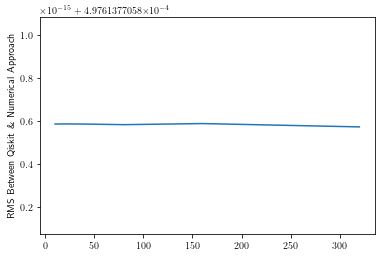

In [9]:

#Get circuit operator of evolution for a given time step
qiskit_circuit = QuantumCircuit(2*nsites, 2*nsites)
hc.qc_evolve(qiskit_circuit, nsites, 0.05, t, U, 50)
qiskit_circuit_operator = Operator(qiskit_circuit)
#Full evolution operator
qiskit_circuit_operator = qiskit_circuit_operator.data

#Create time evolution operator for numerical approach
numerical_hamiltonian = fhc.get_hamiltonian(states, t, U)
numerical_time_evolution = la.expm(-1j*numerical_hamiltonian*0.05)

#
#Calculate the real, imaginary, and absolute rms between the two operators
# as a function of Trotter steps
rms_trots = []
re_rms_trots = []
im_rms_trots = []
trotter_slices = [10, 20, 40, 80, 160, 320]#, 640, 1280, 2560, 5120]
for trot_slice in trotter_slices:
    print(trot_slice)
    sq_diff = 0.
    re_sq_diff = 0.
    im_sq_diff = 0.
    qiskit_circuit = QuantumCircuit(2*nsites, 2*nsites)
    hc.qc_evolve(qiskit_circuit, nsites, 0.05, t, U, trot_slice)
    qiskit_circuit_operator = Operator(qiskit_circuit)
    qiskit_circuit_operator = qiskit_circuit_operator.data
    for i in range(len(numerical_time_evolution)):
        for j in range(len(numerical_time_evolution[0])):
            sq_diff += (numerical_time_evolution[i][j] - qiskit_circuit_operator[i][j])*np.conj(numerical_time_evolution[i][j] - qiskit_circuit_operator[i][j])
            re_sq_diff += (np.real(numerical_time_evolution[i][j]) - np.real(qiskit_circuit_operator[i][j]))**2
            im_sq_diff += (np.imag(numerical_time_evolution[i][j]) - np.imag(qiskit_circuit_operator[i][j]))**2
    rms = sq_diff / (len(numerical_time_evolution)*len(numerical_time_evolution[0]))
    re_rms = re_sq_diff / (len(numerical_time_evolution)*len(numerical_time_evolution[0]))
    im_rms = im_sq_diff / (len(numerical_time_evolution)*len(numerical_time_evolution[0]))
    rms_trots.append(rms)
    re_rms_trots.append(re_rms)
    im_rms_trots.append(im_rms)

#print(qiskit_circuit_operator)
#print(numerical_time_evolution)
#print("Fideltiy: ", fidelity(numerical_time_evolution, qiskit_circuit_operator))
plt.plot(trotter_slices, rms_trots)
plt.ylabel("RMS Between Qiskit \& Numerical Approach")
print(rms_trots)

[(0.010783720713848791+0j), (0.010783715794125777+0j), (0.010783714567467259+0j), (0.010783714261006666+0j), (0.010783714184403846+0j), (0.010783714165253441+0j)]


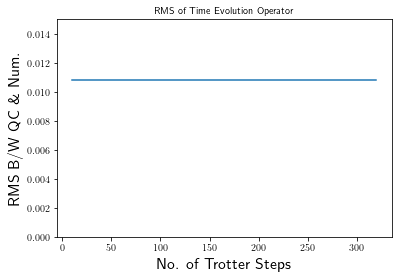

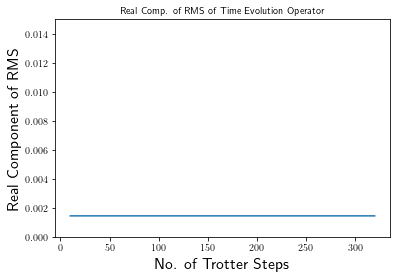

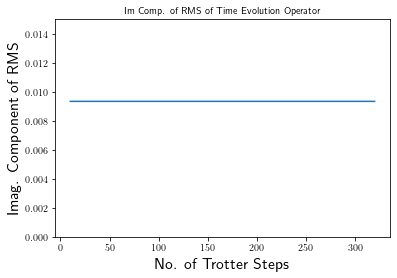

In [27]:
plt.plot(trotter_slices, rms_trots)
plt.ylabel("RMS B/W QC \& Num.", size=16)
plt.xlabel("No. of Trotter Steps", size=16)
plt.title("RMS of Time Evolution Operator", size=10)
plt.ylim(0,0.015)
print(rms_trots)
plt.show()

plt.plot(trotter_slices, re_rms_trots)
plt.ylabel("Real Component of RMS", size=16)
plt.xlabel("No. of Trotter Steps", size=16)
plt.title("Real Comp. of RMS of Time Evolution Operator", size=10)
plt.ylim(0, 0.015)
plt.show()


plt.plot(trotter_slices, im_rms_trots)
plt.ylabel("Imag. Component of RMS", size=16)
plt.xlabel("No. of Trotter Steps", size=16)
plt.title("Im Comp. of RMS of Time Evolution Operator", size=10)
plt.ylim(0, 0.015)
plt.show()

### Compare State Vectors

In [ ]:
#Function to calculate wavefunction overlap given two state vectors
def wfk_overlap(psi_1, psi_2):
    fidelity = np.dot(np.conj(psi_1), psi_2)
    return fidelity

print(wfks[0])
print(run_results4[0])
print(wfk_overlap(wfks[0],run_results4[0]))

### Calculate Fidelity

In [14]:
#Get density matrix of numerical approach at the last step of the time evolution
# NOTE: This cell will not work if you have no run sys_evolve_den() to simulate Hubbard evolution on Qiskit
numerical_density = np.outer(wfks[-1],np.conj(wfks[-1]))



#Calculate the fidelity b/w two density matrices
def fidelity(numerical_density, quantum_density):
    sqrt_quantum = la.sqrtm(quantum_density)
    fidelity_matrix = np.matmul(sqrt_quantum, np.matmul(numerical_density,sqrt_quantum))
    fidelity_matrix = la.sqrtm(fidelity_matrix)
    trace = np.trace(fidelity_matrix)
    trace2 = np.conj(trace)*trace
    #Try tr(rho*sigma)+sqrt(det(rho)*det(sigma))
    #fidelity = np.trace(np.matmul(numerical_density, quantum_density)) + np.sqrt(np.linalg.det(numerical_density)*np.linalg.det(quantum_density))
    return trace2

print("Fidelity")
print( fidelity( run_results4[-1], numerical_density) )
print( fidelity( numerical_density, run_results4[-1])) 
print('============================')
print('Trace')
print('Numerical: ',np.trace(numerical_density))
print('Quantum: ',np.trace(run_results2[-1]))
print('============================')
print('Square Trace')
print('Numerical: ',np.trace(np.matmul(numerical_density, numerical_density)))
print('Quantum: ',np.trace(np.matmul(run_results2[-1], run_results2[-1])))
print('============================')

#Compare values element by element
max_diff = 0.
index = [0,0]
index = [0,0]
for i in range(len(numerical_density)):
    for j in range(len(numerical_density)):
        if numerical_density[i,j] != run_results2[-1][i][j]:
            if abs(numerical_density[i,j]-run_results2[-1][i][j]) > 0.001:
                print('Numerical: ', numerical_density[i,j],'    Quantum: ',run_results2[-1][i][j])
                print("Difference: ", abs(numerical_density[i,j]-run_results2[-1][i][j]))
                if max_diff < abs(numerical_density[i,j]-run_results2[-1][i][j]):
                    max_diff = abs(numerical_density[i,j]-run_results2[-1][i][j])
                    index = [i,j]

fidelities1 = []
fidelities2 = []
fidelities3 = []
fidelities4 = []
fidelities5 = []
fidelities6 = []

#Calculate fidelity as a function of time for a given number of Trotter steps
for t in range(len(times)):
    num_density = np.outer(wfks[t],np.conj(wfks[t]))
    fidelities1.append(fidelity(num_density, run_results1[t]))
    fidelities2.append(fidelity(num_density, run_results2[t]))
    fidelities3.append(fidelity(num_density, run_results3[t]))
    fidelities4.append(fidelity(num_density, run_results4[t]))
    fidelities5.append(fidelity(num_density, run_results5[t]))
    fidelities6.append(fidelity(num_density, run_results6[t]))

trotters = [10, 20, 30, 40, 50, 60]
plt.plot(times, fidelities3, label="10 Steps")
plt.plot(times, fidelities4, label="20 Steps")
plt.plot(times, fidelities5, label="30 Steps")
plt.plot(times, fidelities6, label="40 Steps")
plt.ylabel("Fidelity", size=18)
plt.xlabel("Time", size=18)
#plt.ylim(0.8,1.1)
#plt.title(r"Fidelity of 3 Site Chain w/ Superposition b/w 010000 and 010010", fontsize=18)
plt.legend()
#plt.ylim(0.5,1.)
print(fidelities3)
print("===============================")
print("Max Difference: ",max_diff, "   Index: ",index)

Fidelity


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 20)

## Density Matrix Eigenvalues

In [72]:
#Get density matrices fromt the 1st and last time step of numerical approach
# then calculate their eigenvalues/vectors
numerical_den0 = np.outer(wfks[0],np.conj(wfks[0]))
numerical_den_end = np.outer(wfks[-1],np.conj(wfks[-1]))
num_eigs_begin = la.eig(numerical_den0)
num_eigs_end = la.eig(numerical_den_end)


#Get eigenvalues from density matrix of qiskit run at first and last time step
qiskit_eigs_begin = la.eig(run_results1[0])
qiskit_eigs_end = la.eig(run_results1[-1])

print("Fidelity")
print("Beginning: ",fidelity(numerical_den0, run_results1[0]))
print("End: ",fidelity(numerical_den_end, run_results1[-1]))
print("Eigenvalues")
print("Qiskit                                                Numerical")
"""
for i in range(len(num_eigs_end)):
    print(qiskit_eigs_end[i],'         ',num_eigs_end[i])
"""
    
for t in range(len(times)):
    numerical_den = np.outer(wfks[t],np.conj(wfks[t]))
    numerical_eigs = la.eig(numerical_den)
    #print("Numerical Eigs: ",type(numerical_eigs))
    qiskit_den_eigs = la.eig(run_results6[t])
    print("====================================================")
    print("Eigenvalues for time:  ", t*0.25)
    print("Qiskit                                                Numerical")
    for eig in range(len(numerical_eigs)):
        if abs(numerical_eigs[0][eig]) > 1e-5 or abs(qiskit_den_eigs[0][eig]) > 1e-5:
            print(qiskit_eigs_end[0][eig],'         ',num_eigs_end[0][eig])
            print("Nonzero Indices: ")
            print("Qiskit: ",np.nonzero(qiskit_eigs_end[1][eig]),"                        Numerical: ",np.nonzero(num_eigs_end[1][eig]))
            #print("Eigenvectors: ")
            #print(qiskit_eigs_end[1][eig],'         ',num_eigs_end[1][eig])
    #print("====================================================")
#print(num_eigs_end)
#print(qiskit_eigs_end)

Fidelity
Beginning:  (1+0j)
End:  (0.3729575231292201+0j)
Eigenvalues
Qiskit                                                Numerical
Eigenvalues for time:   0.0
Qiskit                                                Numerical
Eigenvalues for time:   0.25
Qiskit                                                Numerical
(2.7184446498983107e-16+4.8755550720590703e-17j)           (0.9999999999999978-2.195983558408505e-17j)
Nonzero Indices: 
Qiskit:  (array([17]),)                         Numerical:  (array([10]),)
Eigenvalues for time:   0.5
Qiskit                                                Numerical
(2.7184446498983107e-16+4.8755550720590703e-17j)           (0.9999999999999978-2.195983558408505e-17j)
Nonzero Indices: 
Qiskit:  (array([17]),)                         Numerical:  (array([10]),)
Eigenvalues for time:   0.75
Qiskit                                                Numerical
(1.0000000000000067+2.2184867678139993e-17j)           (-4.9829955334034654e-17+2.195983558408505e-17j)


<hr style="border:2px solid black"> </hr>

# Time Evolution Data
<hr style="border:1px solid black"> </hr>


## Run Qiskit Evolution w/ Energy Measurement

In [12]:
#==========Set Parameters of the System=============#
dt = 0.25 #Delta t
T = 5.
time_steps = int(T/dt)
t = 1.0  #Hopping parameter
#t = [1.0, 2.]
U = 2.  #On-Site repulsion
#time_steps = 10
nsites = 3
trotter_slices = 10
initial_state = np.array([1])

#Run simulation
run_results1, eng1 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 50)
run_results2, eng2 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 60)
run_results3, eng3 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 70)
run_results4, eng4 = hc.sys_evolve_eng(nsites, initial_state, T, dt, t, U, 80)

Num Steps:  20
Total Time:  5.0
Job:  1  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  1  of  20  complete
Job:  2  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  2  of  20  complete
Job:  3  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  3  of  20  complete
Job:  4  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  4  of  20  complete
Job:  5  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  5  of  20  complete
Job:  6  of  20  computing energy...
Job Status: job has successfully run
Job Status: job has successfully run
Total Energy is:  0.0
Job:  6  of  20  complete
Job:  7  of  2

## Run Evolution Numerically

In [ ]:
#System parameters
t = .0
U = 2.
classical_time_step = 0.25
classical_total_time = T
times = np.arange(0., classical_total_time, classical_time_step)

#Create basis states
states = fhc.get_states(nsites)
print(states)

#If desired, find the index of a specific state to initialize wavefuntion
target_state = [[1,0,1], [0,0,0]]
target_index = 0
for l in range(len(states)):
    if len(target_state) == sum([1 for i, j in zip(target_state, states[l]) if i == j]):
        print('Target state found at: ',l)
        target_index = l
        print(states[target_index])



#Initialize wavefunction
wfk_full = np.zeros(len(states), dtype=np.complex_)



#Set the amplitude for the initial state
wfk_full[18] = 1.    #010010 #Indices 1, 4
#wfk_full[21] = 1.    #010101 #Indices 0,2,4
#wfk_full[42] = 1.    #101010
#wfk_full[2] = 1.   #000010
#wfk_full[16] = 1.   #010000
#wfk_full[target_index] = 1.
#wfk_full[2] = 0.5 - 0.5*1j
#wfk_full[0] = 1/np.sqrt(2)



#Run time evolution numerically, evolution are the occupation of fermionic modes, wfks are the
# wavefunctions themselves at each time step
evolution, engs, wfks = fhc.sys_evolve(states, wfk_full, t, U, classical_total_time, classical_time_step)


## Process and Plot the Data

No handles with labels found to put in legend.
No handles with labels found to put in legend.


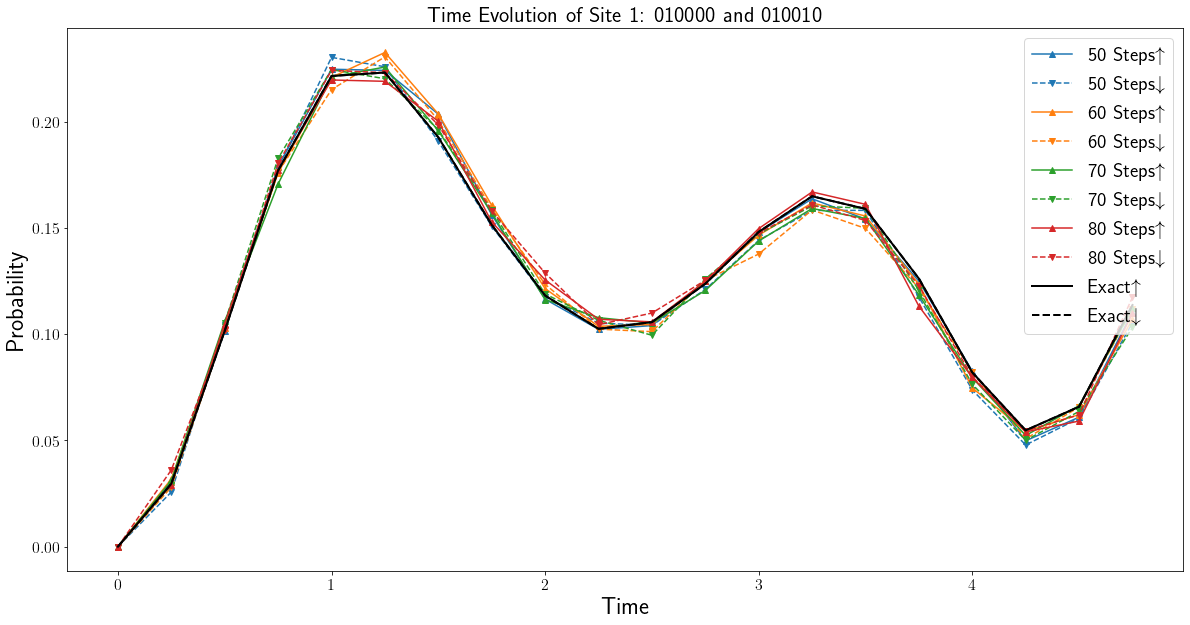

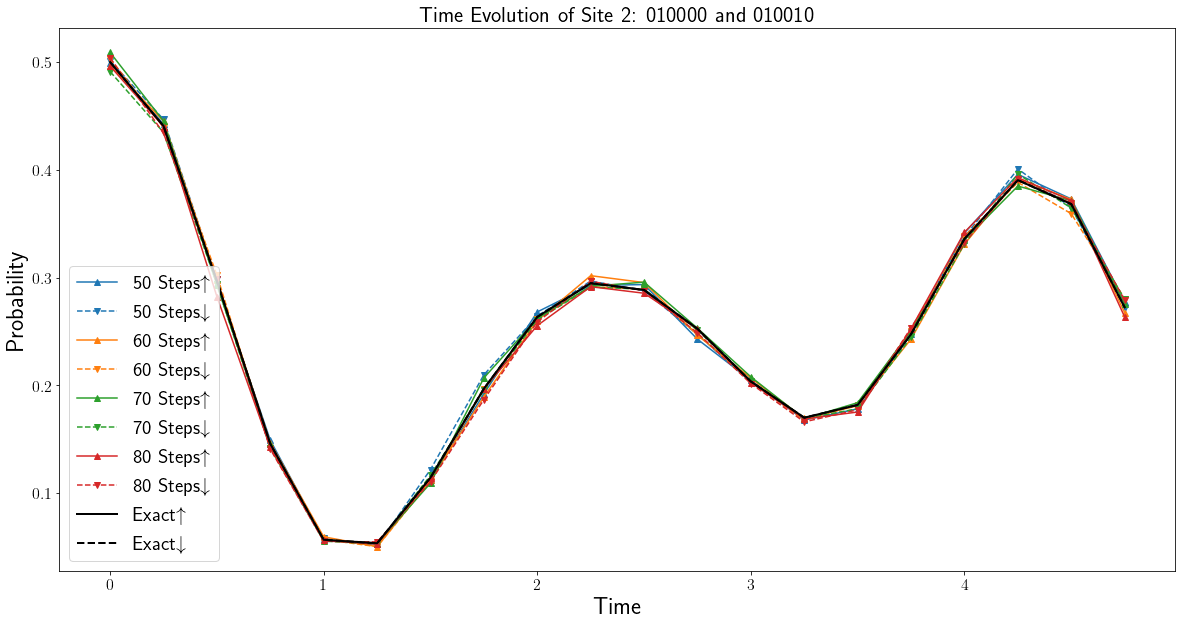

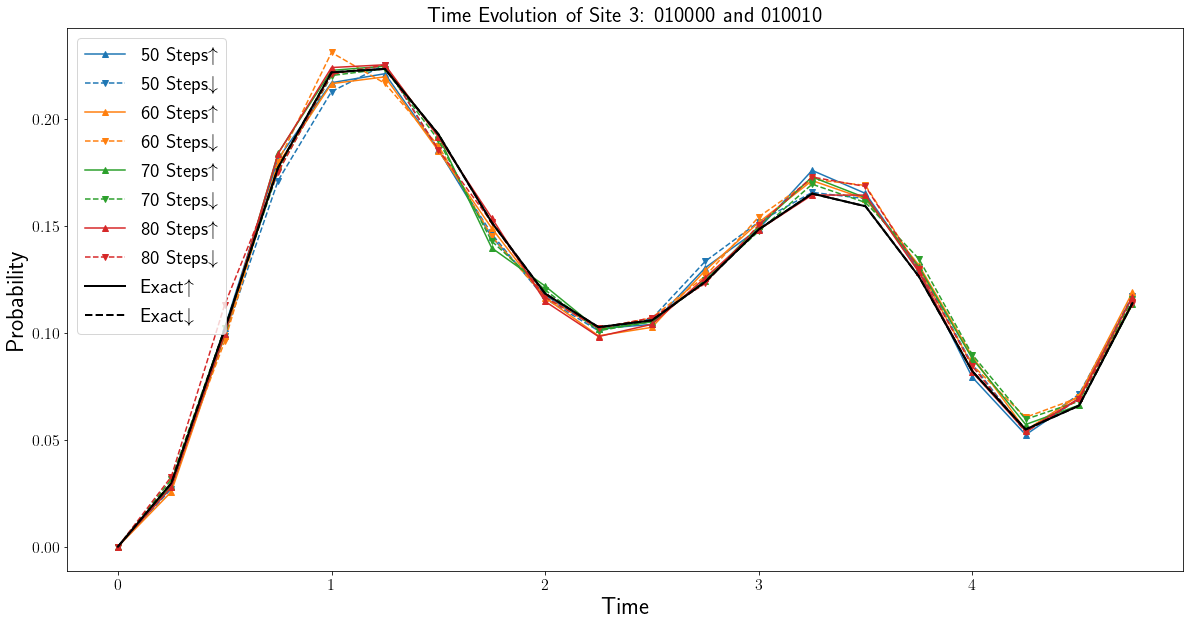

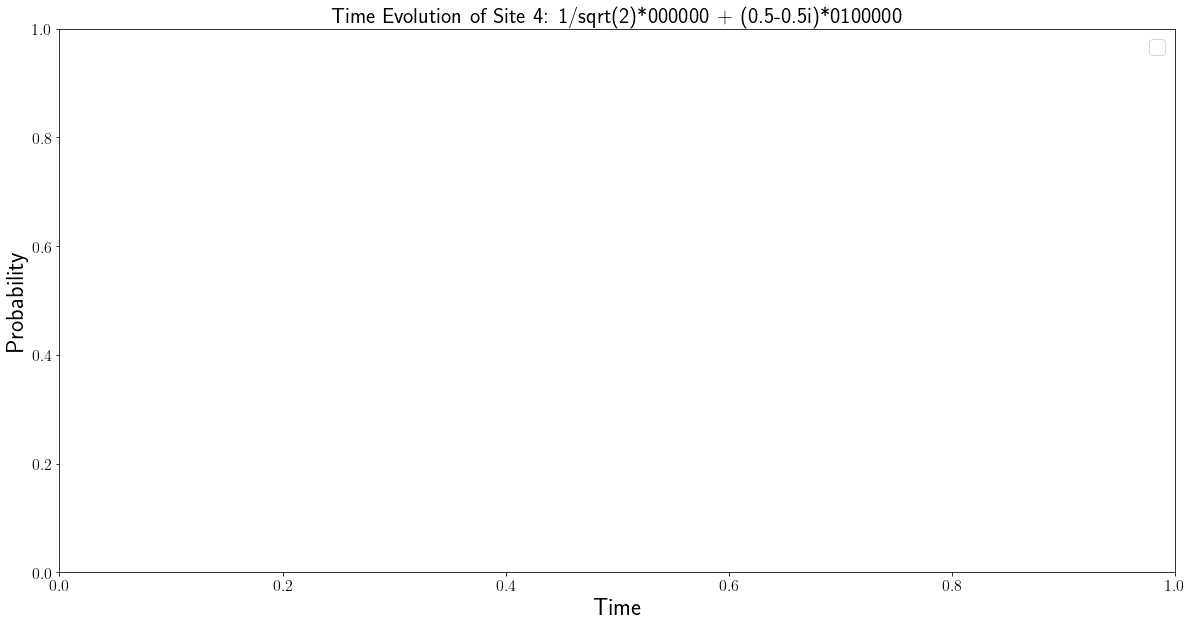

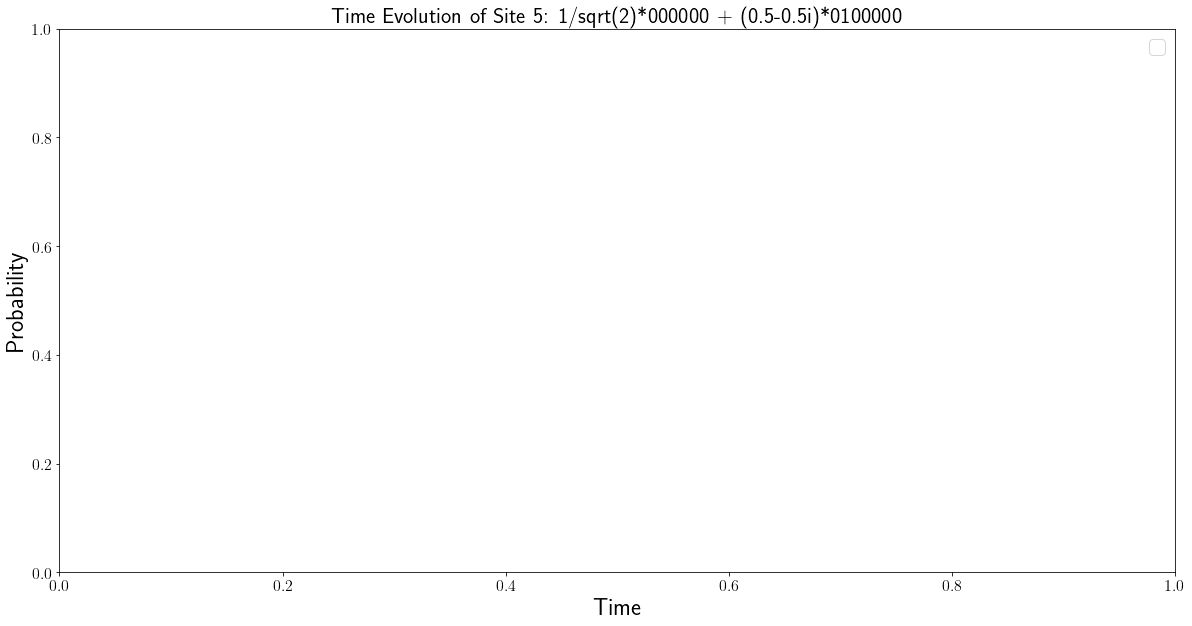

In [15]:
#Process the qiskit data into fermionic modes
processed_data1 = hc.process_run(nsites, time_steps, dt, run_results1)
processed_data2 = hc.process_run(nsites, time_steps, dt, run_results2)
processed_data3 = hc.process_run(nsites, time_steps, dt, run_results3)
processed_data4 = hc.process_run(nsites, time_steps, dt, run_results4)
timesq = np.arange(0, time_steps*dt, dt)

#Create plots of the processed data
# with separate fig and axes objects for each site in the chain
#fig0, ax0 = plt.subplots(figsize=(20,10))
fig1, ax1 = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
fig3, ax3 = plt.subplots(figsize=(20,10))
fig4, ax4 = plt.subplots(figsize=(20,10))
fig5, ax5 = plt.subplots(figsize=(20,10))
colors = list(mcolors.TABLEAU_COLORS.keys())

'''
#Plot energies
ax0.plot(timesq, eng1, color=str(colors[0]), label='10 Steps')
ax0.plot(timesq, eng2, color=str(colors[1]), label='20 Steps')
ax0.plot(timesq, eng3, color=str(colors[2]), label='40 Steps')
ax0.plot(timesq, eng4, color=str(colors[3]), label='60 Steps')
ax0.legend(fontsize=20)
ax0.set_xlabel("Time", fontsize=24)
ax0.set_ylabel("Total Energy", fontsize=24)
ax0.tick_params(labelsize=16)
'''

#################################################################################
#Plot Site 1
strup = "50 Steps"+r'$\uparrow$'
strdwn = "50 Steps"+r'$\downarrow$'
ax1.plot(timesq, processed_data1[0,:], marker="^", color=str(colors[0]), label=strup)
ax1.plot(timesq, processed_data1[0+nsites,:], linestyle='--', marker="v", color=str(colors[0]), label=strdwn)
strup = "60 Steps"+r'$\uparrow$'
strdwn = "60 Steps"+r'$\downarrow$'
ax1.plot(timesq, processed_data2[0,:], marker="^", color=str(colors[1]), label=strup)
ax1.plot(timesq, processed_data2[0+nsites,:], linestyle='--', marker="v", color=str(colors[1]), label=strdwn)
strup = "70 Steps"+r'$\uparrow$'
strdwn = "70 Steps"+r'$\downarrow$'
ax1.plot(timesq, processed_data3[0,:], marker="^", color=str(colors[2]), label=strup)
ax1.plot(timesq, processed_data3[0+nsites,:],linestyle='--', marker="v", color=str(colors[2]), label=strdwn)
strup = "80 Steps"+r'$\uparrow$'
strdwn = "80 Steps"+r'$\downarrow$'
ax1.plot(timesq, processed_data4[0,:], marker="^", color=str(colors[3]), label=strup)
ax1.plot(timesq, processed_data4[0+nsites,:], linestyle='--', marker="v", color=str(colors[3]), label=strdwn)
strup = "Exact"+r'$\uparrow$'
strdwn = "Exact"+r'$\downarrow$'
#Numerical evolution
ax1.plot(times, evolution[:,0], linestyle='-', color='k', linewidth=2, label=strup)
ax1.plot(times, evolution[:,0+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)


#################################################################################
#Plot Site 2
strup = "50 Steps"+r'$\uparrow$'
strdwn = "50 Steps"+r'$\downarrow$'
ax2.plot(timesq, processed_data1[1,:], marker="^", color=str(colors[0]), label=strup)
ax2.plot(timesq, processed_data1[1+nsites,:], marker="v", linestyle='--',color=str(colors[0]), label=strdwn)
strup = "60 Steps"+r'$\uparrow$'
strdwn = "60 Steps"+r'$\downarrow$'
ax2.plot(timesq, processed_data2[1,:], marker="^", color=str(colors[1]), label=strup)
ax2.plot(timesq, processed_data2[1+nsites,:], marker="v", linestyle='--',color=str(colors[1]), label=strdwn)
strup = "70 Steps"+r'$\uparrow$'
strdwn = "70 Steps"+r'$\downarrow$'
ax2.plot(timesq, processed_data3[1,:], marker="^", color=str(colors[2]), label=strup)
ax2.plot(timesq, processed_data3[1+nsites,:], marker="v", linestyle='--', color=str(colors[2]), label=strdwn)
strup = "80 Steps"+r'$\uparrow$'
strdwn = "80 Steps"+r'$\downarrow$'
ax2.plot(timesq, processed_data4[1,:], marker="^", color=str(colors[3]), label=strup)
ax2.plot(timesq, processed_data4[1+nsites,:], marker="v", linestyle='--', color=str(colors[3]), label=strdwn)
#Numerical evolution
strup = "Exact"+r'$\uparrow$'
strdwn = "Exact"+r'$\downarrow$'
ax2.plot(times, evolution[:,1], linestyle='-', color='k', linewidth=2, label=strup)
ax2.plot(times, evolution[:,1+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)



#################################################################################
#Site 3
strup = "50 Steps"+r'$\uparrow$'
strdwn = "50 Steps"+r'$\downarrow$'
ax3.plot(timesq, processed_data1[2,:], marker="^", color=str(colors[0]), label=strup)
ax3.plot(timesq, processed_data1[2+nsites,:], marker="v", linestyle='--', color=str(colors[0]), label=strdwn)
strup = "60 Steps"+r'$\uparrow$'
strdwn = "60 Steps"+r'$\downarrow$'
ax3.plot(timesq, processed_data2[2,:], marker="^", color=str(colors[1]), label=strup)
ax3.plot(timesq, processed_data2[2+nsites,:], marker="v", linestyle='--', color=str(colors[1]), label=strdwn)
strup = "70 Steps"+r'$\uparrow$'
strdwn = "70 Steps"+r'$\downarrow$'
ax3.plot(timesq, processed_data3[2,:], marker="^", color=str(colors[2]), label=strup)
ax3.plot(timesq, processed_data3[2+nsites,:], marker="v", linestyle='--', color=str(colors[2]), label=strdwn)
strup = "80 Steps"+r'$\uparrow$'
strdwn = "80 Steps"+r'$\downarrow$'
ax3.plot(timesq, processed_data4[2,:], marker="^", color=str(colors[3]), label=strup)
ax3.plot(timesq, processed_data4[2+nsites,:], marker="v", linestyle='--', color=str(colors[3]), label=strdwn)
#Numerical evolution
strup = "Exact"+r'$\uparrow$'
strdwn = "Exact"+r'$\downarrow$'
ax3.plot(times, evolution[:,2], linestyle='-', color='k', linewidth=2, label=strup)
ax3.plot(times, evolution[:,2+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)


#Add in more sites if desired
r'''
#Site 4

strup = "10 Steps"+r'$\uparrow$'
strdwn = "10 Steps"+r'$\downarrow$'

#ax4.plot(timesq, processed_data1[3,:], marker="^", color=str(colors[0]), label=strup)
#ax4.plot(timesq, processed_data1[3+nsites,:], marker="v", linestyle='--', color=str(colors[0]), label=strdwn)
strup = "40 Steps"+r'$\uparrow$'
strdwn = "40 Steps"+r'$\downarrow$'
#ax4.plot(timesq, processed_data2[3,:], marker="^", color=str(colors[1]), label=strup)
#ax4.plot(timesq, processed_data2[3+nsites,:], marker="v", linestyle='--', color=str(colors[1]), label=strdwn)
strup = "150 Steps"+r'$\uparrow$'
strdwn = "150 Steps"+r'$\downarrow$'
ax4.plot(timesq, processed_data3[3,:], marker="^", color=str(colors[2]), label=strup)
ax4.plot(timesq, processed_data3[3+nsites,:], marker="v", linestyle='--', color=str(colors[2]), label=strdwn)
strup = "100 Steps"+r'$\uparrow$'
strdwn = "100 Steps"+r'$\downarrow$'
#ax4.plot(timesq, processed_data4[3,:], marker="^", color=str(colors[3]), label=strup)
#ax4.plot(timesq, processed_data4[3+nsites,:], marker="v", linestyle='--', color=str(colors[3]), label=strdwn)
#1e numerical evolution
strup = "Exact"+r'$\uparrow$'
strdwn = "Exact"+r'$\downarrow$'
ax4.plot(times, evolution[:,3], linestyle='-', color='k', linewidth=2, label=strup)
ax4.plot(times, evolution[:,3+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)

#2e+ numerical evolution
#ax3.plot(times, mode_evolve[:,2], linestyle='-', color='k', linewidth=2, label=strup)
#ax3.plot(times, mode_evolve[:,2+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)



#Site 5
strup = "10 Steps"+r'$\uparrow$'
strdwn = "10 Steps"+r'$\downarrow$'
ax5.plot(timesq, processed_data1[4,:], marker="^", color=str(colors[0]), label=strup)
ax5.plot(timesq, processed_data1[4+nsites,:], marker="v", linestyle='--', color=str(colors[0]), label=strdwn)
strup = "40 Steps"+r'$\uparrow$'
strdwn = "40 Steps"+r'$\downarrow$'
#ax5.plot(timesq, processed_data2[4,:], marker="^", color=str(colors[1]), label=strup)
#ax5.plot(timesq, processed_data2[4+nsites,:], marker="v", linestyle='--', color=str(colors[1]), label=strdwn)
strup = "150 Steps"+r'$\uparrow$'
strdwn = "150 Steps"+r'$\downarrow$'
ax5.plot(timesq, processed_data3[4,:], marker="^", color=str(colors[2]), label=strup)
ax5.plot(timesq, processed_data3[4+nsites,:], marker="v", linestyle='--', color=str(colors[2]), label=strdwn)
strup = "100 Steps"+r'$\uparrow$'
strdwn = "100 Steps"+r'$\downarrow$'
#ax5.plot(timesq, processed_data4[4,:], marker="^", color=str(colors[3]), label=strup)
#ax5.plot(timesq, processed_data4[4+nsites,:], marker="v", linestyle='--', color=str(colors[3]), label=strdwn)
#1e numerical evolution
strup = "Exact"+r'$\uparrow$'
strdwn = "Exact"+r'$\downarrow$'
ax5.plot(times, evolution[:,4], linestyle='-', color='k', linewidth=2, label=strup)
ax5.plot(times, evolution[:,4+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)

#2e+ numerical evolution
#ax3.plot(times, mode_evolve[:,2], linestyle='-', color='k', linewidth=2, label=strup)
#ax3.plot(times, mode_evolve[:,2+nsites], linestyle='--', color='k', linewidth=2, label=strdwn)
r'''

#ax2.set_ylim(0, 0.55)
#ax2.set_xlim(0, time_steps*dt+dt/2.)
#ax2.set_xticks(np.arange(0,time_steps*dt+dt, 0.2))
#ax2.set_yticks(np.arange(0,0.55, 0.05))
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax1.set_title(r"Time Evolution of Site 1: 010000 and 010010", fontsize=22)
ax2.set_title(r"Time Evolution of Site 2: 010000 and 010010", fontsize=22)
ax3.set_title(r"Time Evolution of Site 3: 010000 and 010010", fontsize=22)
ax4.set_title(r"Time Evolution of Site 4: 1/sqrt(2)*000000 + (0.5-0.5i)*0100000", fontsize=22)
ax5.set_title(r"Time Evolution of Site 5: 1/sqrt(2)*000000 + (0.5-0.5i)*0100000", fontsize=22)
ax1.set_xlabel('Time', fontsize=24)
ax2.set_xlabel('Time', fontsize=24)
ax3.set_xlabel('Time', fontsize=24)
ax4.set_xlabel('Time', fontsize=24)
ax5.set_xlabel('Time', fontsize=24)
ax1.set_ylabel('Probability', fontsize=24)
ax2.set_ylabel('Probability', fontsize=24)
ax3.set_ylabel('Probability', fontsize=24)
ax4.set_ylabel('Probability', fontsize=24)
ax5.set_ylabel('Probability', fontsize=24)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax3.legend(fontsize=20)
ax4.legend(fontsize=20)
ax5.legend(fontsize=20)



## Plot Energies

NameError: name 'engs4' is not defined

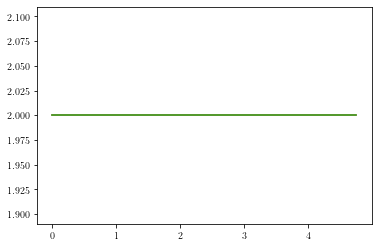

In [7]:
plt.plot(times, engs1, label="10 Steps")
plt.plot(times, engs2, label="30 Steps")
plt.plot(times, engs3, label="60 Steps")
plt.plot(times, engs4, label="90 Steps")
plt.plot(times, engs,'k', label="Exact")
plt.legend(bbox_to_anchor=(0.02, 0.6, .2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

plt.xlabel("Time", fontsize=18)
plt.ylabel("Energy [t]", fontsize=18)
plt.title("Energy of 010010, t=0")
#plt.ylim(-0.1, 0.1)
print(engs)